## Valley-Eagle-7B

* From ByteDance
* Rank #37 in OpenCompass multimodal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimodal)

    * The underlying modeling_valley.py is identical with the one used by Valley2-DPO
    * Use the modified modeling_valley.py for Valley-Eagle-7B for Valley2-DPO because the former is more updated than the latter.

In [1]:
import sys
import os
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

# Add the desired directory to the Python path
sys.path.append(os.path.abspath('/data/students/earl/llava-dissector/Valley-Eagle-7B'))

model_path = '/data/students/earl/llava-dissector/Valley-Eagle-7B'
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map='auto').eval()#.to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)



/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/data/students/earl/anaconda3/envs/rca/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/data/students/ea

[0.44, 0.34, 0.51, 0.38]
Bounding Boxes: [[0.44, 0.34, 0.51, 0.38]]


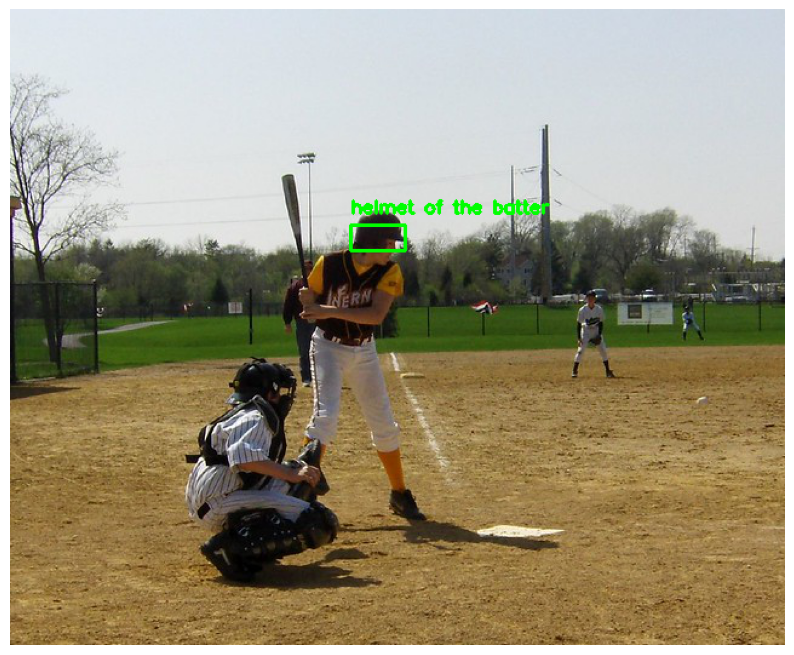

In [ ]:
import urllib
from io import BytesIO
from PIL import Image
import re
import requests
import cv2
from matplotlib import pyplot as plt
import numpy as np


cls = "helmet of the batter"
model.threshold = None #-1.5

text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.'
url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
img = urllib.request.urlopen(url=url, timeout=5).read()
img = Image.open(BytesIO(img)).convert("RGB")
res = processor(
    {
        "conversations": 
        [
            {"role": "system", "content": "You are Valley, developed by ByteDance. Your are a helpfull Assistant. You provide the bounding box coordinates of all instances of an object class when asked."},
            {"role": "user", "content": {text}},
            #{"role": "user", "content": "Describe the given image."},
            #{"role": "user", "content": f"Provide the bounding box coordinates of {cls}"},
        ], 
        "images": [img]
    }, 
    inference=True
)


with torch.inference_mode():
    #model.to(dtype=torch.float16, device=device)
    output_ids = model.generate(
        input_ids=res["input_ids"],#.to(device),
        #images=[[item.to(dtype=torch.float16, device=device) for item in img] for img in res["images"]],
        images=[[item.to(dtype=torch.bfloat16) for item in img] for img in res["images"]],
        image_sizes=res["image_sizes"],
        pixel_values=res["pixel_values"].to(dtype=torch.bfloat16),#, device=device),
        image_grid_thw=res["image_grid_thw"],#.to(device),
        do_sample=False,
        max_new_tokens=1024,
        repetition_penalty=1.0,
        return_dict_in_generate=True,
        output_scores=True,
    )
input_token_len = res["input_ids"].shape[1]
generation_text = processor.batch_decode(output_ids.sequences[:, input_token_len:])[0]
generation_text = response = generation_text.replace("<|im_end|>", "")
print(generation_text)


# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 


In [ ]:
res['attention_mask']